# Body Waves Site Effect

In [ ]:
## Distributed python packages
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from math import radians, log

from wmsan.subfunctions_body_waves import open_bathy, ampli

__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2024, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "2025.0.0"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@gmail.com"
__status__ = "Production"

## Spatial Extent

In [2]:
# extent
lat_min = 30 # -78 min
lat_max = 50 # 80 max
lon_min = 0 # -180 min
lon_max = 20 # 180 max

extent = [lon_min, lon_max, lat_min, lat_max]

## Bathymetry file 
The bathymetry (or waterlevel) is necessary to compute the site effect for a given phase.

Two bathymetry grids are available for this notebook: 
- (default) "../../data/LOPS_WW3-GLOB-30M_dataref_dpt.nc": a 0.5°x0.5° bathymetry file corresponding to WW3 hindcast resolution.

- (to download) a 1 arcmin resolution ETOPOv2 bathymetry netcdf file.(```refined_bathymetry = True```) 

Both file should be located in the ```ww3-source-maps/data/``` directory.

ETOPOv2 file is also available here: https://www.ngdc.noaa.gov/thredds/catalog/global/ETOPO2022/60s/60s_bed_elev_netcdf/catalog.html?dataset=globalDatasetScan/ETOPO2022/60s/60s_bed_elev_netcdf/ETOPO_2022_v1_60s_N90W180_bed.nc
- [WARNING] use this refined bathymetry on small grids otherwise memory errors might occur (typically 30° lat x 30° lon)

If you wish to use your own bathymetry file:
- latitude in ° 1D array should be named ```zlat```.
- longitude in ° 1D array should be named ```zlon```.
- depth in meters 2D grid should be named ```dpt1```.

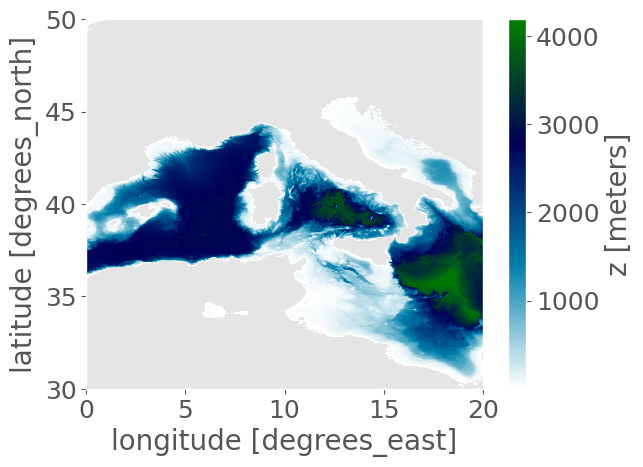

In [3]:
# bathymetry default
file_bathy = "../../data/LOPS_WW3-GLOB-30M_dataref_dpt.nc"  #0.5x0.5 degree grid bathymetry
dpt1, zlon, zlat = open_bathy(file_bathy, refined_bathymetry=True, extent=extent)

if dpt1 is None:
    print("Use default bathymetry or download refined.")
else:
    # Plot
    dpt1.plot(cmap='ocean_r')
    plt.show()

## Amplification Coefficients 
We compute the amplification coefficient for body waves (or ocean site effect on body waves) as:

$$c_{P/S}(f) = \sqrt{\int_0^{\theta^*_{P_w}} \left \vert \frac{T_{P/S}(\theta_{P_w})}{1+R(\theta_{P_w}\exp ^{i\phi_w(h(r), 2\pi f,\theta_{P_w})})}\right \vert^2 d\theta_{P_w}}$$

with:
-  $f$ the seismic frequency, 
-  $h$ the ocean depth in m,
-  $\theta_{P_w}$ (default 15.71°) the P-wave takeoff angle range,
-  $\Phi_w$ the plane P-wave potential propagating in water,
-  $R$ the seabed interface reflection coefficient
-  $T_{P/S}$ the seabed interface P or S wave transmission coefficient. 


For details on the computation see references:
- [Gualtieri, L., Stutzmann, É., Farra, V., Capdeville, Y., Schimmel, M., Ardhuin, F., & Morelli, A. (2014). Modelling the ocean site effect on seismic noise body waves. Geophysical Journal International, 197(2), 1096-1106.](https://doi.org/10.1093/gji/ggu042)

In [4]:
if os.path.isfile('../../data/cP_custom.nc'):
    cP = xr.open_dataarray('../../data/cP_custom.nc')
    cS = xr.open_dataarray('../../data/cS_custom.nc')
    f = cP.frequency.values
else:
    # Amplification Coefficient Computation
    print("THIS SHOULD TAKE 30 MINUTES TO RUN")
    fpath = './'
    f = np.array([0.08203799, 0.0902418, 0.09926598, 0.10919258, 0.12011184, 0.13212304,
                0.14533535, 0.15986888, 0.17585577, 0.19344135, 0.21278548, 0.23406404,
                0.25747046, 0.28321752, 0.3115393,  0.34269324, 0.37696257, 0.41465884,
                0.45612472, 0.50173724, 0.55191094, 0.60710204])
    cP, cS, bathy_ampli_P, bathy_ampli_S = ampli(dpt1.values, f)
    region = [np.min(zlon), np.max(zlon), np.min(zlat), np.max(zlat)]

THIS SHOULD TAKE 30 MINUTES TO RUN


/Users/tomasetl/opt/miniconda3/envs/wmsan_test/lib/python3.12/site-packages/wmsan/subfunctions_body_waves.py:284: RuntimeWarning: invalid value encountered in reciprocal
  C = 1*np.reciprocal(1 + Rpp[i]*np.exp(1j*phi*qw[i]))
/Users/tomasetl/opt/miniconda3/envs/wmsan_test/lib/python3.12/site-packages/numpy/lib/scimath.py:135: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


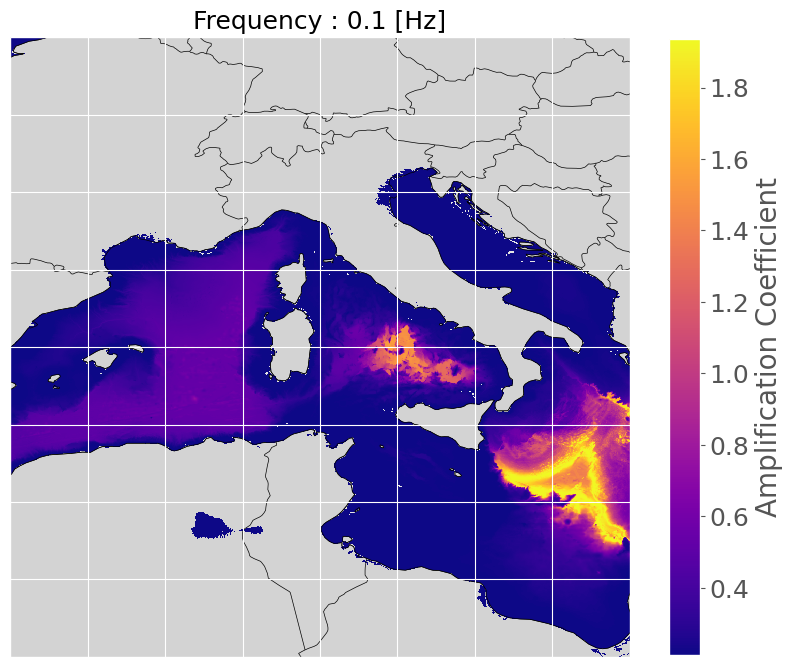

In [5]:
frequency_value = 0.1
## 
freq_index = np.argmin(np.abs(f - frequency_value))

# Plot 
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("Frequency : %s [Hz]"%frequency_value)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='lightgrey')
im = ax.pcolormesh(zlon, zlat, cP[freq_index, :, :], shading='auto', cmap='plasma', rasterized=True, transform=ccrs.PlateCarree())
plt.colorbar(im, shrink=0.8, ax=ax, label="Amplification Coefficient")
ax.gridlines()
ax.coastlines()
plt.show()

## Save as Netcdf

In [6]:
# Create netCDF 

## cP
ncfile = nc.Dataset("../../data/cP_custom.nc", mode='w',format='NETCDF4_CLASSIC')
lat_dim = ncfile.createDimension('latitude', len(zlat))  # latitude axis
lon_dim = ncfile.createDimension('longitude', len(zlon))  # longitude axis
freq_dim = ncfile.createDimension('frequency', len(f))
ncfile.title='Amplification Coefficient P-waves',
ncfile.subtitle='Amplification Coefficient P-waves for custom spatial extent'
lat = ncfile.createVariable('latitude', np.float64, ('latitude',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('longitude', np.float64, ('longitude',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
freq_nc = ncfile.createVariable('frequency', np.float64, ('frequency',))
freq_nc.units = 'Hz'
freq_nc.long_name = 'frequency'
c_P = ncfile.createVariable('cP', np.float64, ('frequency','latitude', 'longitude'))
c_P.units = ''
c_P.long_name = 'Amplification Coefficient P-waves'
lat[:] = zlat
lon[:] = zlon
freq_nc[:] = f
c_P[:] = cP
ncfile.close()

## cS
ncfile = nc.Dataset("../../data/cS_custom.nc", mode='w',format='NETCDF4_CLASSIC')
lat_dim = ncfile.createDimension('latitude', len(zlat))  # latitude axis
lon_dim = ncfile.createDimension('longitude', len(zlon))  # longitude axis
freq_dim = ncfile.createDimension('frequency', len(f))
ncfile.title='Amplification Coefficient S-waves',
ncfile.subtitle='Amplification Coefficient S-waves for custom spatial extent'
lat = ncfile.createVariable('latitude', np.float32, ('latitude',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('longitude', np.float32, ('longitude',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
freq_nc = ncfile.createVariable('frequency', np.float32, ('frequency',))
freq_nc.units = 'Hz'
freq_nc.long_name = 'frequency'
c_S = ncfile.createVariable('cS', np.float32, ('frequency','latitude', 'longitude'))
c_S.units = ''
c_S.long_name = 'Amplification Coefficient S-waves'
lat[:] = zlat
lon[:] = zlon
freq_nc[:] = f
c_S[:] = cS
ncfile.close()